In [1]:
from pyspark.sql.functions import col
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

In [2]:
from pyspark.sql import SparkSession

# Restart the Spark session
spark = SparkSession.builder \
    .appName("SkillsDemandAnalysis") \
    .master("local[*]") \
    .config("spark.executor.memory", "4g") \
    .config("spark.driver.memory", "4g") \
    .getOrCreate()

In [3]:
from pyspark.sql import SparkSession

# Initialize Spark session
spark = SparkSession.builder \
    .appName("SkillsDemandAnalysis") \
    .config("spark.executor.memory", "4g") \
    .config("spark.driver.memory", "4g") \
    .getOrCreate()


In [4]:
# Load cleaned data as DataFrame
data_path = "hdfs://namenode:9000/user/ubuntu/Project_Code/cleaned_job_data_using_spark.csv"
job_data = spark.read.csv(data_path, header=True, inferSchema=True)

# Select required columns and preprocess missing data
selected_columns = ["job_description", "job_skills", "job_industry", 
                    "job_location", "experience_level", "min_salary", "max_salary"]
job_data = job_data.select(selected_columns)


In [5]:
from pyspark.ml.feature import Tokenizer, CountVectorizer, IDF, StringIndexer, VectorAssembler
from pyspark.ml import Pipeline

# Tokenize job descriptions and job skills
tokenizer = Tokenizer(inputCol="job_description", outputCol="job_description_words")
tokenizer_skills = Tokenizer(inputCol="job_skills", outputCol="job_skills_words")

# Vectorize the tokenized words
vectorizer = CountVectorizer(inputCol="job_description_words", outputCol="job_description_features")
vectorizer_skills = CountVectorizer(inputCol="job_skills_words", outputCol="job_skills_features")

# Apply TF-IDF
idf = IDF(inputCol="job_description_features", outputCol="job_description_tfidf")
idf_skills = IDF(inputCol="job_skills_features", outputCol="job_skills_tfidf")

# Index categorical columns
indexer_industry = StringIndexer(inputCol="job_industry", outputCol="job_industry_index")
indexer_location = StringIndexer(inputCol="job_location", outputCol="job_location_index")
indexer_experience = StringIndexer(inputCol="experience_level", outputCol="experience_level_index")

# Assemble features into a single vector
assembler = VectorAssembler(inputCols=["job_description_tfidf", "job_skills_tfidf", 
                                       "job_industry_index", "job_location_index", 
                                       "experience_level_index", "min_salary", "max_salary"], 
                            outputCol="features")

# Create a pipeline
pipeline = Pipeline(stages=[tokenizer, tokenizer_skills, vectorizer, vectorizer_skills, 
                            idf, idf_skills, indexer_industry, indexer_location, 
                            indexer_experience, assembler])

In [6]:
# Fit the model
model = pipeline.fit(job_data)

# Transform the data
clustered_data = model.transform(job_data)

In [7]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

# Apply KMeans clustering
kmeans = KMeans(k=5, seed=42, featuresCol="features", predictionCol="prediction")
kmeans_model = kmeans.fit(clustered_data)
clustered_data = kmeans_model.transform(clustered_data)

# Evaluate clustering using silhouette score
evaluator = ClusteringEvaluator(featuresCol="features", predictionCol="prediction", metricName="silhouette")
silhouette_score = evaluator.evaluate(clustered_data)
print(f"Silhouette Score: {silhouette_score:.3f}")

Silhouette Score: 0.589


In [8]:
from pyspark.sql.functions import col, explode, row_number, collect_list
from pyspark.sql.window import Window

def profile_clusters(clustered_df):
    # Explode the 'words' column and associate with cluster (prediction)
    words_df = clustered_df.select("prediction", explode(col("job_description_words")).alias("word"))
    
    # Group by prediction (cluster) and word, and count occurrences
    word_freq = words_df.groupBy("prediction", "word").count()
    
    # Add a row number for each word within a cluster, ordered by count descending
    window = Window.partitionBy("prediction").orderBy(col("count").desc())
    ranked_words = word_freq.withColumn("rank", row_number().over(window))
    
    # Filter to get top 10 words per cluster
    top_words = ranked_words.filter(col("rank") <= 10).groupBy("prediction").agg(
        collect_list("word").alias("top_words")
    )
    return top_words

# Run the profiling
cluster_profiles = profile_clusters(clustered_data)

# Show the cluster profiles
cluster_profiles.show(truncate=False)

+----------+-------------------------------------------------+
|prediction|top_words                                        |
+----------+-------------------------------------------------+
|0         |[and, to, you, do, what, ll, with, they, for, in]|
|1         |[and, to, you, what, do, ll, with, they, in, for]|
|2         |[and, to, you, ll, do, what, with, they, in, for]|
|3         |[and, to, you, what, ll, do, with, they, in, for]|
|4         |[and, to, you, do, ll, what, with, they, in, for]|
+----------+-------------------------------------------------+



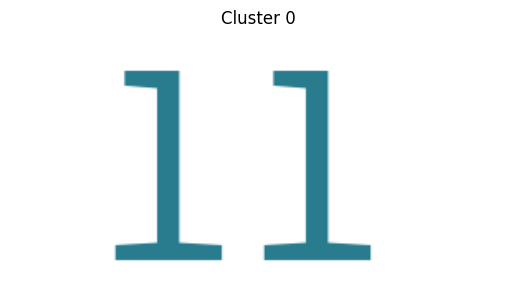

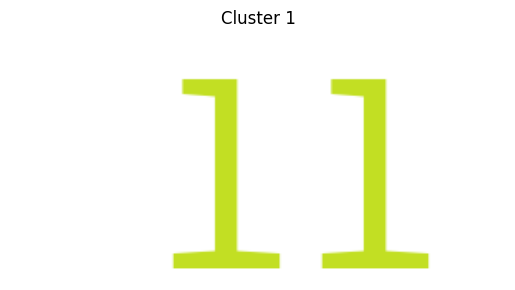

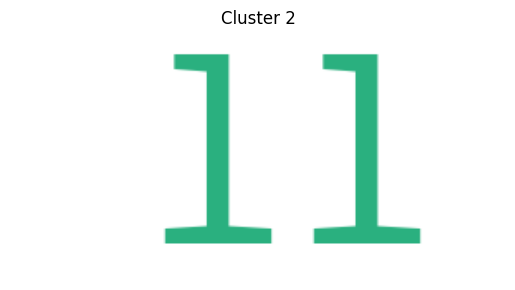

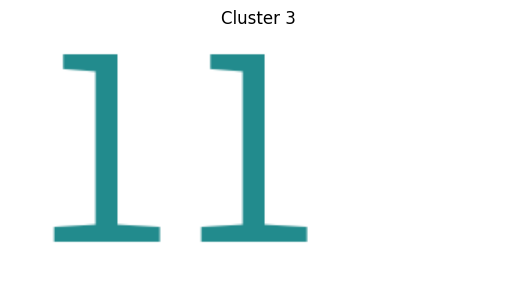

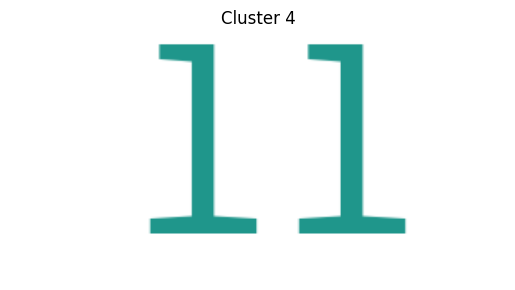

In [9]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def generate_wordclouds(cluster_profiles):
    for row in cluster_profiles.collect():
        cluster_id = row['prediction']
        words = row['top_words']
        wordcloud = WordCloud(width=300, height=150, background_color='white').generate(" ".join(words))
        plt.figure()
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.title(f"Cluster {cluster_id}")
        plt.axis("off")
        plt.show()

# Generate word clouds
generate_wordclouds(cluster_profiles)

In [10]:
# Export clustered data to CSV
output_path = "/home/ubuntu/Project_Code/clustered_job_data_analysis.csv"
clustered_data.select("job_description", "job_skills", "job_industry", "prediction").write.csv(output_path, header=True)

AnalysisException: [PATH_ALREADY_EXISTS] Path hdfs://namenode:9000/home/ubuntu/Project_Code/clustered_job_data_analysis.csv already exists. Set mode as "overwrite" to overwrite the existing path.

In [11]:
import os

# Check if the directory exists
if os.path.exists(output_path):
    print(f"Directory {output_path} exists.")
    # List the contents of the directory
    print("Contents of the directory:")
    print(os.listdir(output_path))
else:
    print(f"Directory {output_path} does not exist.")

Directory /home/ubuntu/Project_Code/clustered_job_data_analysis.csv does not exist.
